In [1]:
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [2]:
import sys
sys.path.append('../')
import Image

Number of y points with frequency > 10: 75
Number of x points with frequency > 10: 22


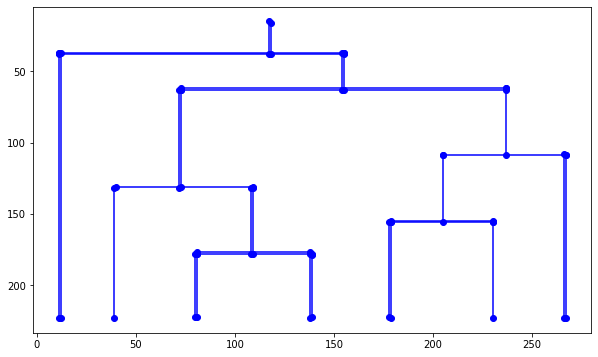

[Step 1] finding and plotting all intersections


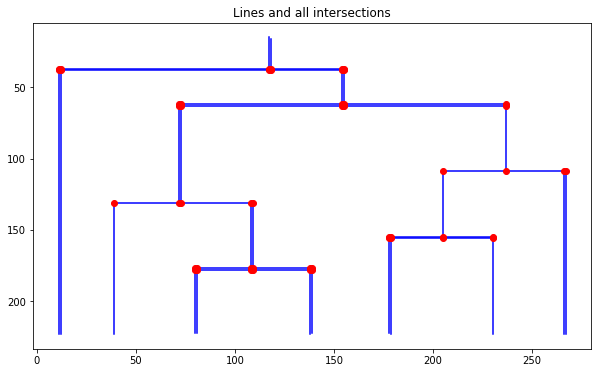

[Step 2] filtering internal nodes (line intersections)
Initial number of intersections = 51
After filtering number of intersections = 18


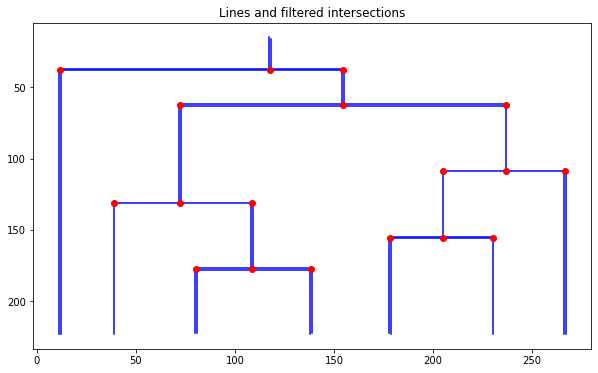

[Step 3] filtering leaves (line endings)
Initial number of intersections = 12
After filtering number of intersections = 7


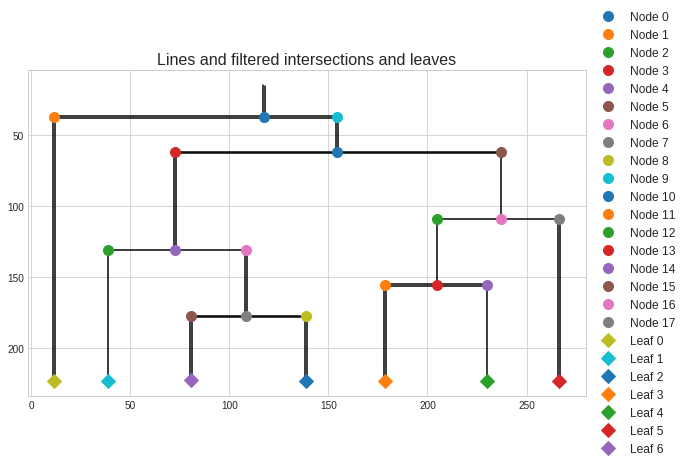

[Summary] number of leaves = 7, number of nodes = 18


In [3]:
image = Image.Image('../test_data/dendogram2.png')
v_lines, h_lines, filtered_intersections, filtered_leaves = image.find_lines_intersections_leaves(legend=True,
                                                                                                 orientation="vertical")

Number of y points with frequency > 10: 235
Number of x points with frequency > 10: 35


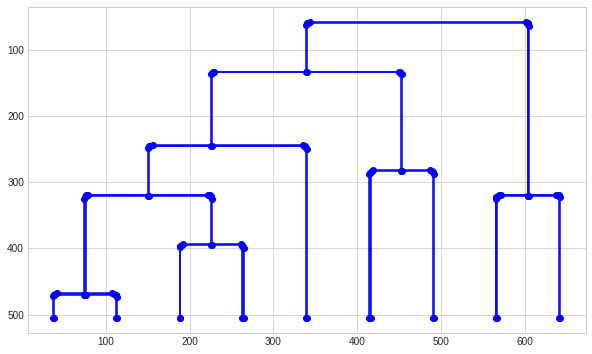

[Step 1] finding and plotting all intersections


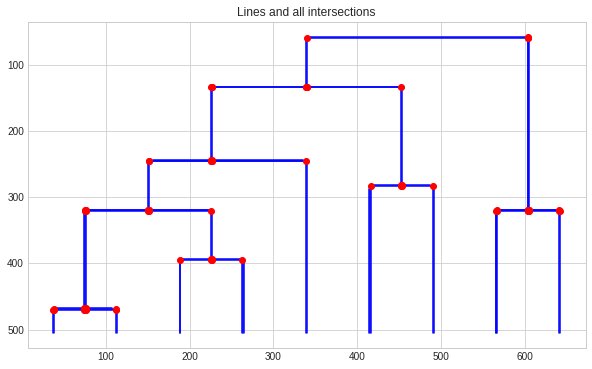

[Step 2] filtering internal nodes (line intersections)
Initial number of intersections = 73
After filtering number of intersections = 23


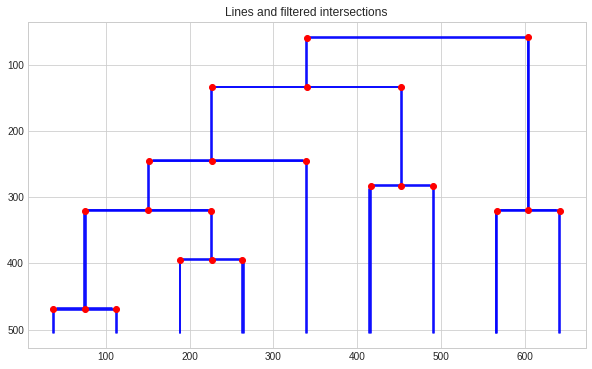

[Step 3] filtering leaves (line endings)
Initial number of intersections = 21
After filtering number of intersections = 9


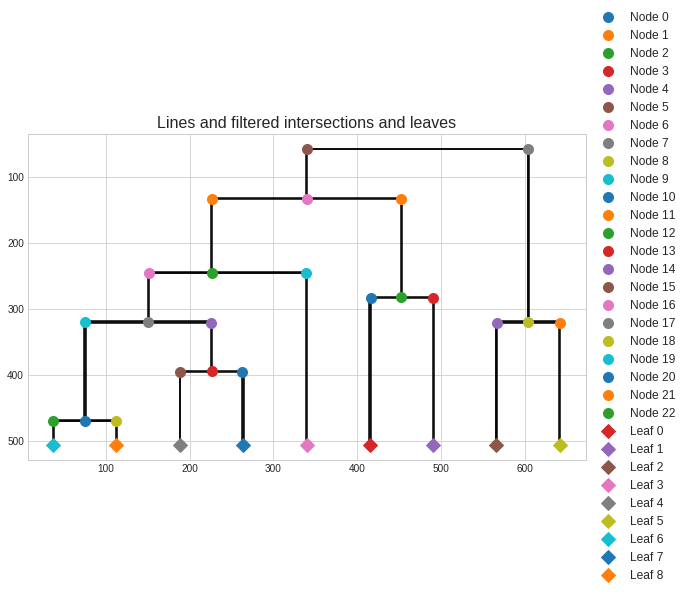

[Summary] number of leaves = 9, number of nodes = 23


In [4]:
image = Image.Image('../test_data/dendrogram_without_text.png')
v_lines, h_lines, filtered_intersections, filtered_leaves = image.find_lines_intersections_leaves(legend=True, 
                                                                                                 orientation="vertical")

Number of y points with frequency > 10: 35
Number of x points with frequency > 10: 235


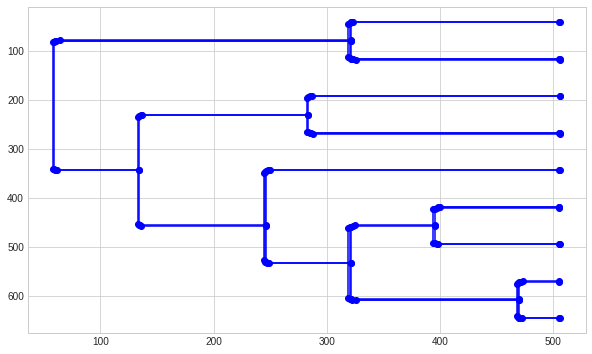

[Step 1] finding and plotting all intersections


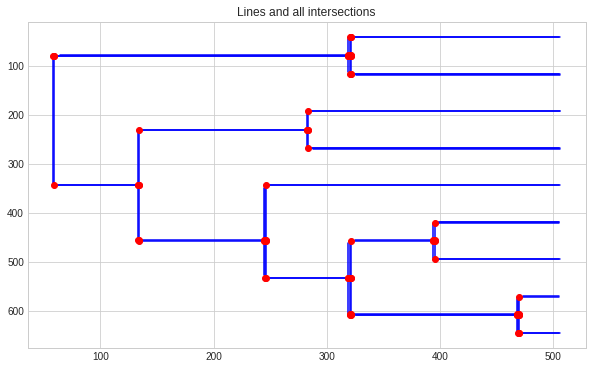

[Step 2] filtering internal nodes (line intersections)
Initial number of intersections = 72
After filtering number of intersections = 23


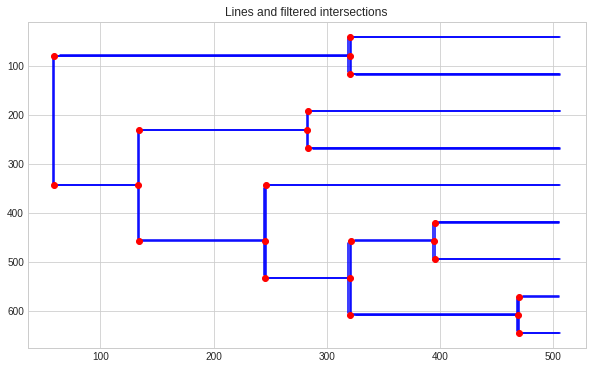

[Step 3] filtering leaves (line endings)
Initial number of intersections = 21
After filtering number of intersections = 9


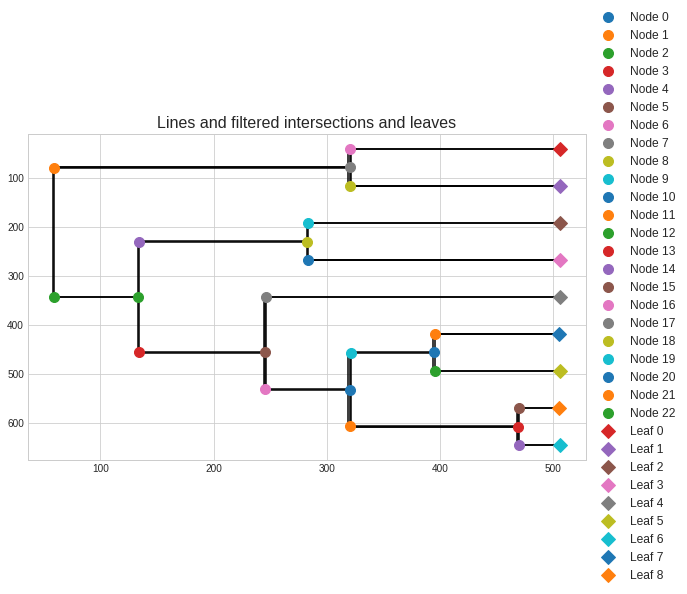

[Summary] number of leaves = 9, number of nodes = 23


In [5]:
image = Image.Image('../test_data/dendrogram_without_text_inverted.png')
v_lines, h_lines, filtered_intersections, filtered_leaves = image.find_lines_intersections_leaves(legend=True,
                                                                                                 orientation='horizontal')

Number of y points with frequency > 10: 151
Number of x points with frequency > 10: 402


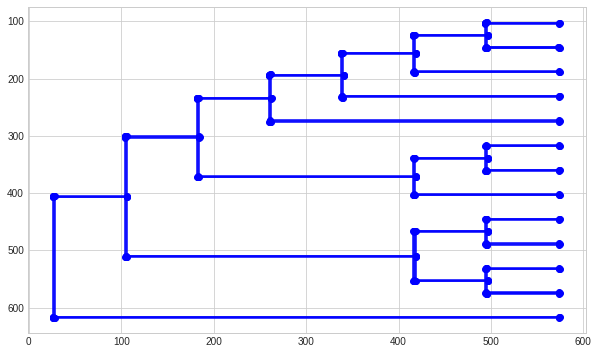

[Step 1] finding and plotting all intersections


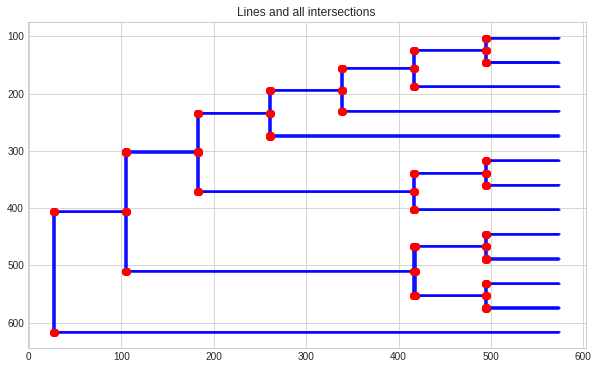

[Step 2] filtering internal nodes (line intersections)
Initial number of intersections = 330
After filtering number of intersections = 35


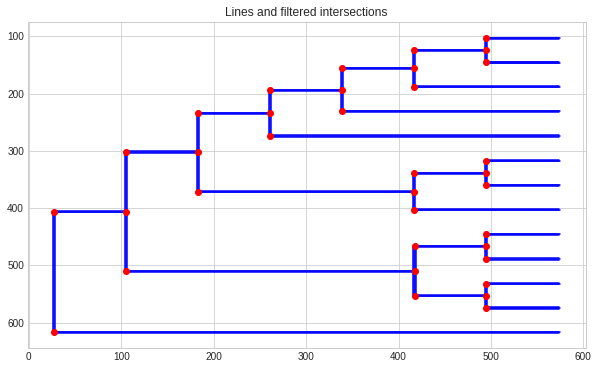

[Step 3] filtering leaves (line endings)
Initial number of intersections = 41
After filtering number of intersections = 13


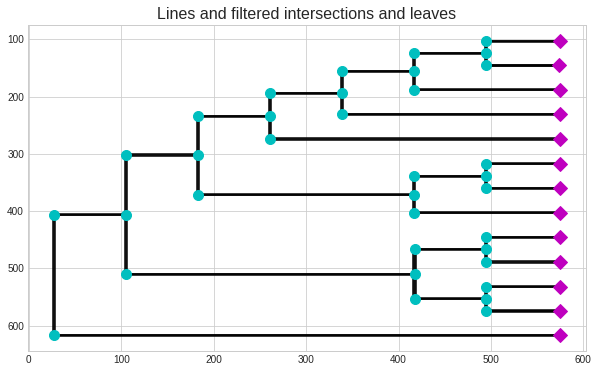

[Summary] number of leaves = 13, number of nodes = 35


In [6]:
image = Image.Image('../test_data/asia_tree1.png')
v_lines, h_lines, filtered_intersections, filtered_leaves = image.find_lines_intersections_leaves(legend=False,
                                                                                                 orientation='horizontal')

# Klasa
artybuty:
- bnw_image
- linie pionowe
- linie poziome
- orientacja drzewa - podana przez użytkownika

metody:
- convert to BnW
- niezerowe pixele
- znajdowanie linii poziomych i pionowych
- znajdowanie przecieć
- znajdowanie liści
- przekrecanie drzewa (ewentualnie?)

In [7]:
def detect_and_vis_lines(image_path, max_gap=2, min_line_length=20, min_freq=10, ymin=None, ymax=None):
    image = Image.Image(image_path)
    print(f"Nonzero = {image.nonzero_pixels[:5]}")

    v_lines, h_lines = image.find_all_lines(max_gap=max_gap, min_line_length=min_line_length, min_freq=min_freq)

    plt.figure(figsize=(10,6))
    for line in v_lines + h_lines:
        if line:
            x1, y1, x2, y2 = line
            plt.plot([x1, x2], [y1, y2], marker='o')
    if ymax is not None and ymin is not None:
        plt.ylim(ymax, ymin)
    plt.show()

Nonzero = [(117, 15), (117, 16), (118, 16), (117, 17), (118, 17)]
Number of y points with frequency > 10: 75
Number of x points with frequency > 10: 22


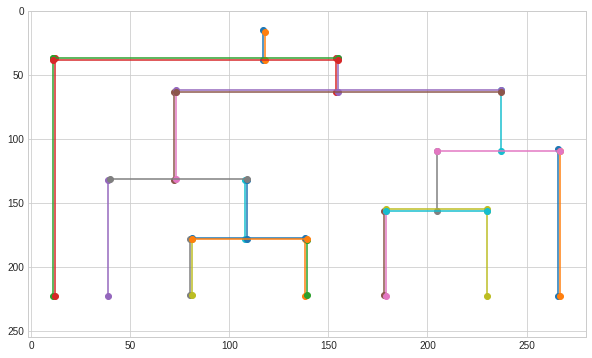

In [8]:
detect_and_vis_lines('../test_data/dendogram2.png', ymax=255, ymin=0)

Number of y points with frequency > 10: 75
Number of x points with frequency > 10: 22


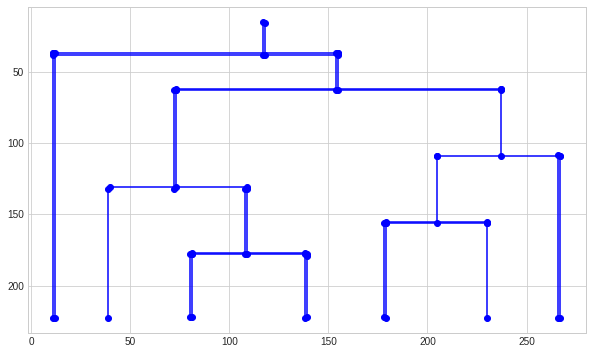

In [9]:
image = Image.Image('../test_data/dendogram2.png')
v_lines, h_lines = image.find_all_lines(max_gap=2, min_line_length=20, min_freq=10)
fig = image.plot_lines(v_lines+h_lines)